In [812]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error

import math

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import patsy

In [813]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# DATA

In [814]:
# Read the data
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-3/main/cs_bisnode_panel.csv")


data = data.query("year != 2016")
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

# Label Engineering

In [815]:
pd.set_option("float_format", "{:.5f}".format)

In [816]:
#Alive in 2014: sales is positive (>0) and not NA, in 2014
data["status_alive2014"] = ((data["sales"] > 0) & (data["sales"].isna() == False) & (data["year"] == 2014)).astype(int)

#Alive in 2015: sales is positive (>0) and not NA, in 2015
data["status_alive2015"] = ((data["sales"] > 0) & (data["sales"].isna() == False) & (data["year"] == 2015)).astype(int)

In [817]:
#Your definition of default should be the following:
# – Existed in 2014 (sales > 0)(status_alive2014 is 1), but did not exists in 2015 (sales is 0 or missing)(status_alive2015 is not 1)
data["default"] = ((data["status_alive2014"] == 1) & (data.groupby("comp_id")["status_alive2015"].shift(-1) != 1)).astype(int)

In [818]:
# drop variables with many NAs
data = data.drop(
   columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

In [819]:
# less than 10mil sales
data = data.loc[data["sales"] < 10000000]

In [820]:
# change negative sales values into 1
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"])

In [821]:
# Create log sales, sales in millions, log sales in million

data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [822]:
# 1 year difference in log sales million
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [823]:
# replace age 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

In [824]:
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

# Feature Engineering

In [825]:
# change some industry category codes
# data = data.loc[data["ind2"] == 26]

In [826]:
# Firm characteristics
# age squared
data["age2"] = data["age"] ** 2

# foreign management if more than 50% is foreign
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# to category
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [827]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.00000    267861
1.00000       213
Name: comp_id, dtype: int64

In [828]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [829]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count        268074.00000
mean         360183.29199
std        26358118.25991
min               0.00000
25%            4907.40723
50%           19551.85111
75%           81255.55469
max     10324711168.00000
Name: total_assets_bs, dtype: float64

In [830]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [831]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [832]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [833]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [834]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [835]:
data = data.drop(["labor_avg"], axis=1)

In [836]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [837]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

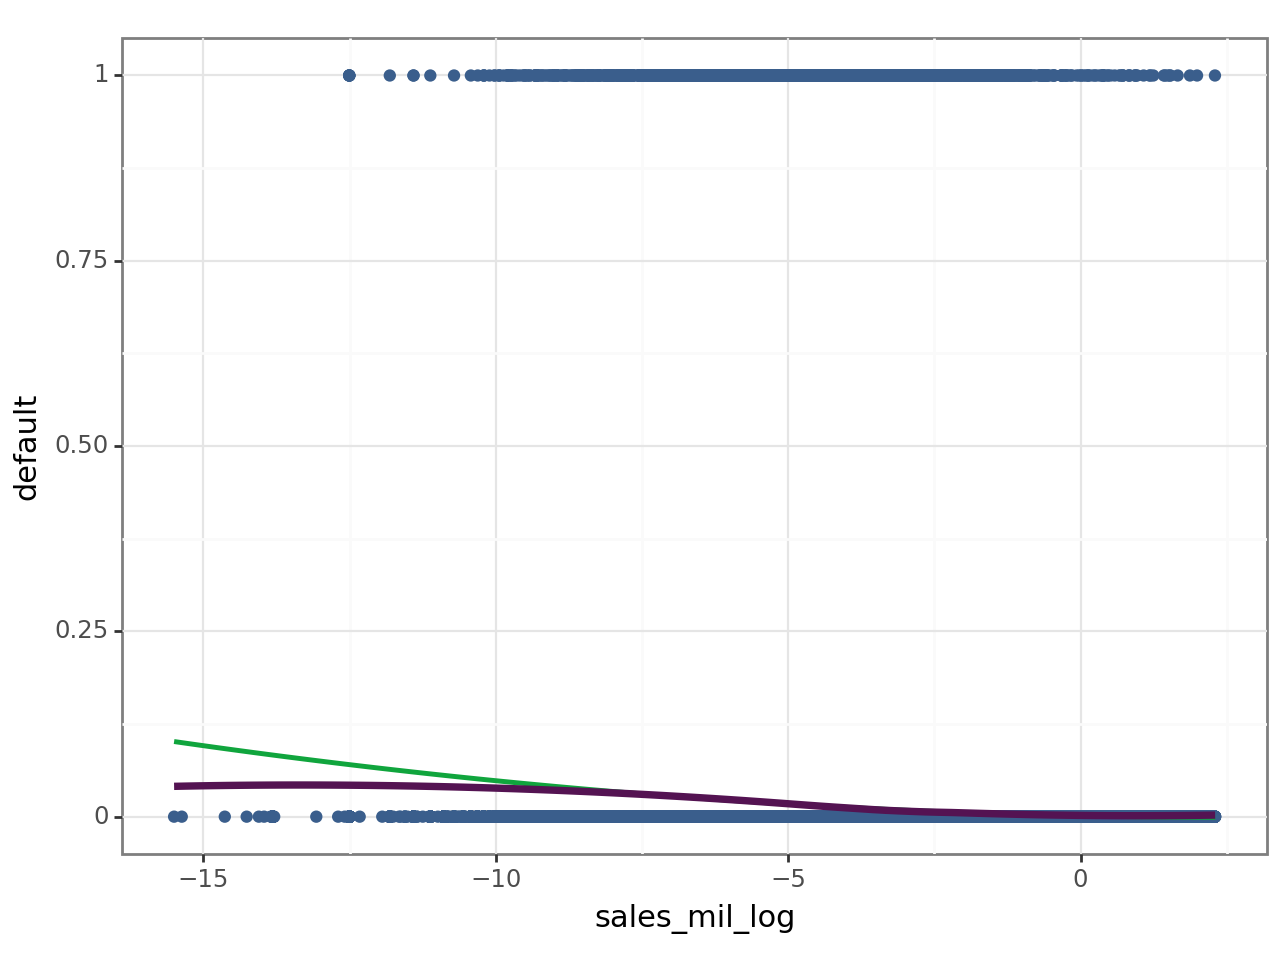

<Figure Size: (640 x 480)>

In [838]:
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)

In [839]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     923.6
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:57:20   Log-Likelihood:             2.5184e+05
No. Observations:              268212   AIC:                        -5.037e+05
Df Residuals:                  268209   BIC:                        -5.036e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0011      0.000  

In [840]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()

count   268212.00000
mean         0.05178
std          1.27307
min        -13.81551
25%         -0.01824
50%          0.00000
75%          0.06851
max         14.63481
Name: d1_sales_mil_log, dtype: float64

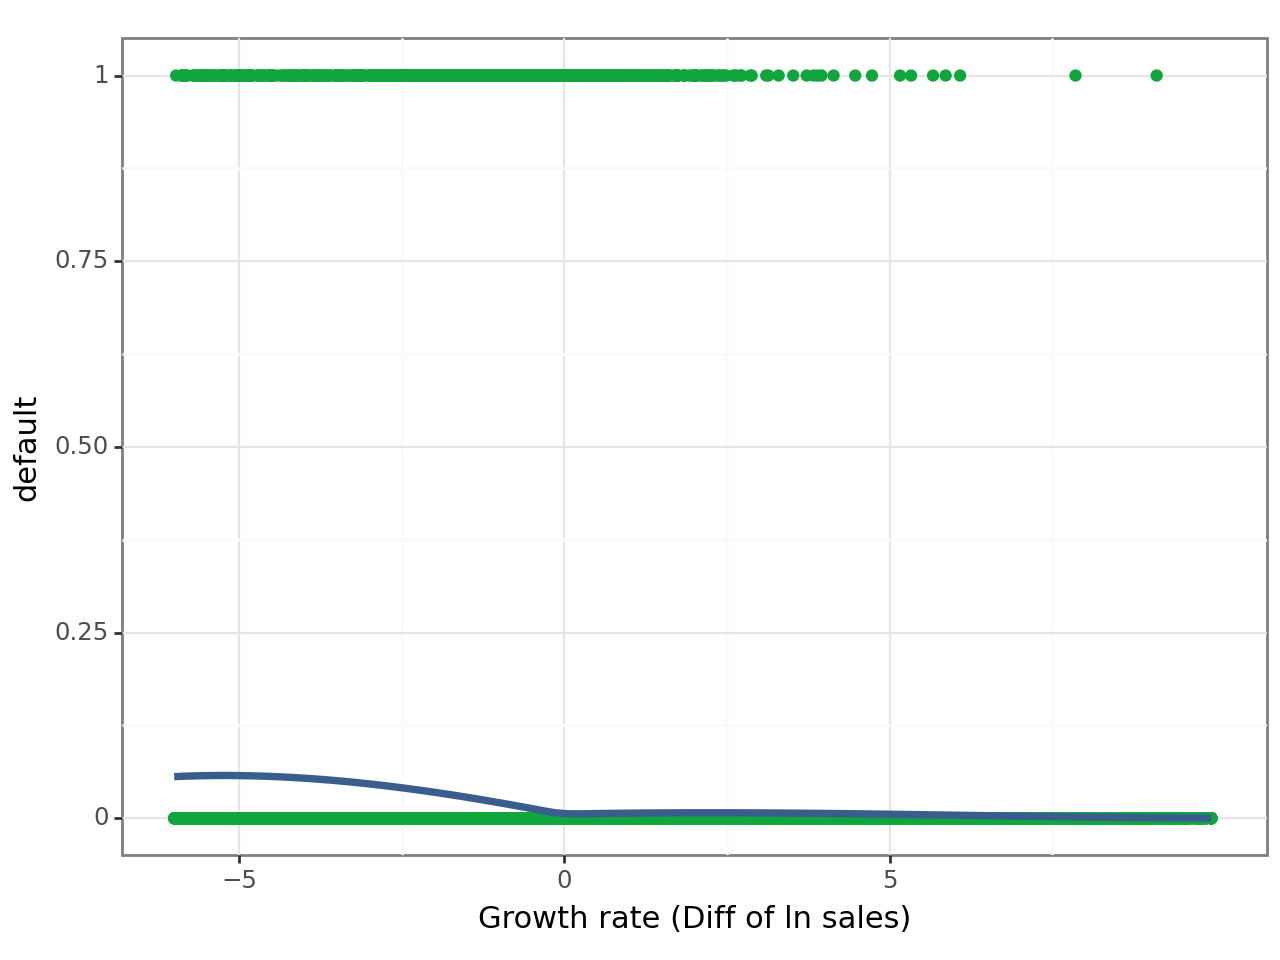

<Figure Size: (640 x 480)>

In [841]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)

In [842]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [843]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

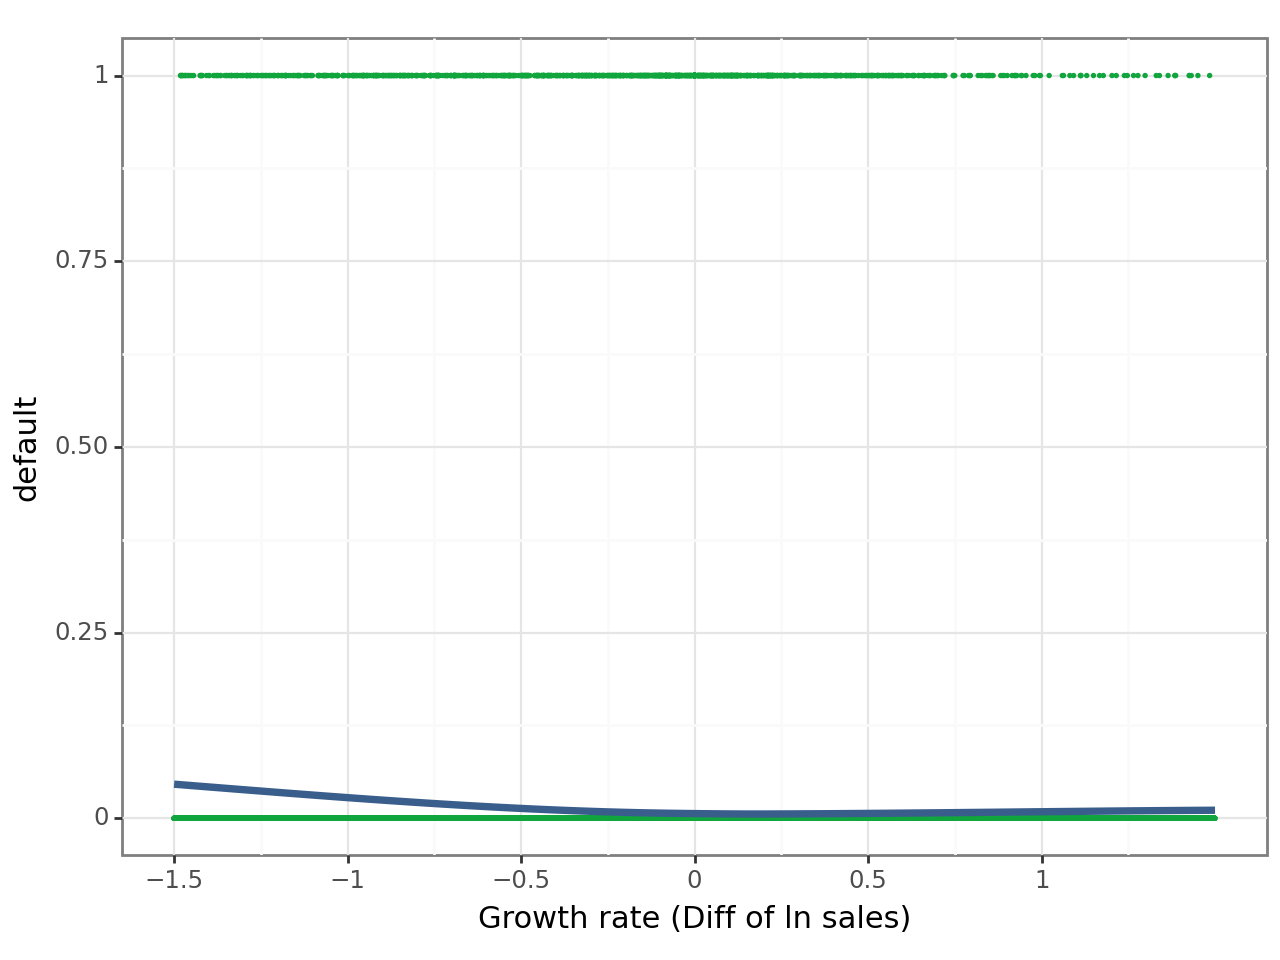

<Figure Size: (640 x 480)>

In [844]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5))
    + theme_bw()
)

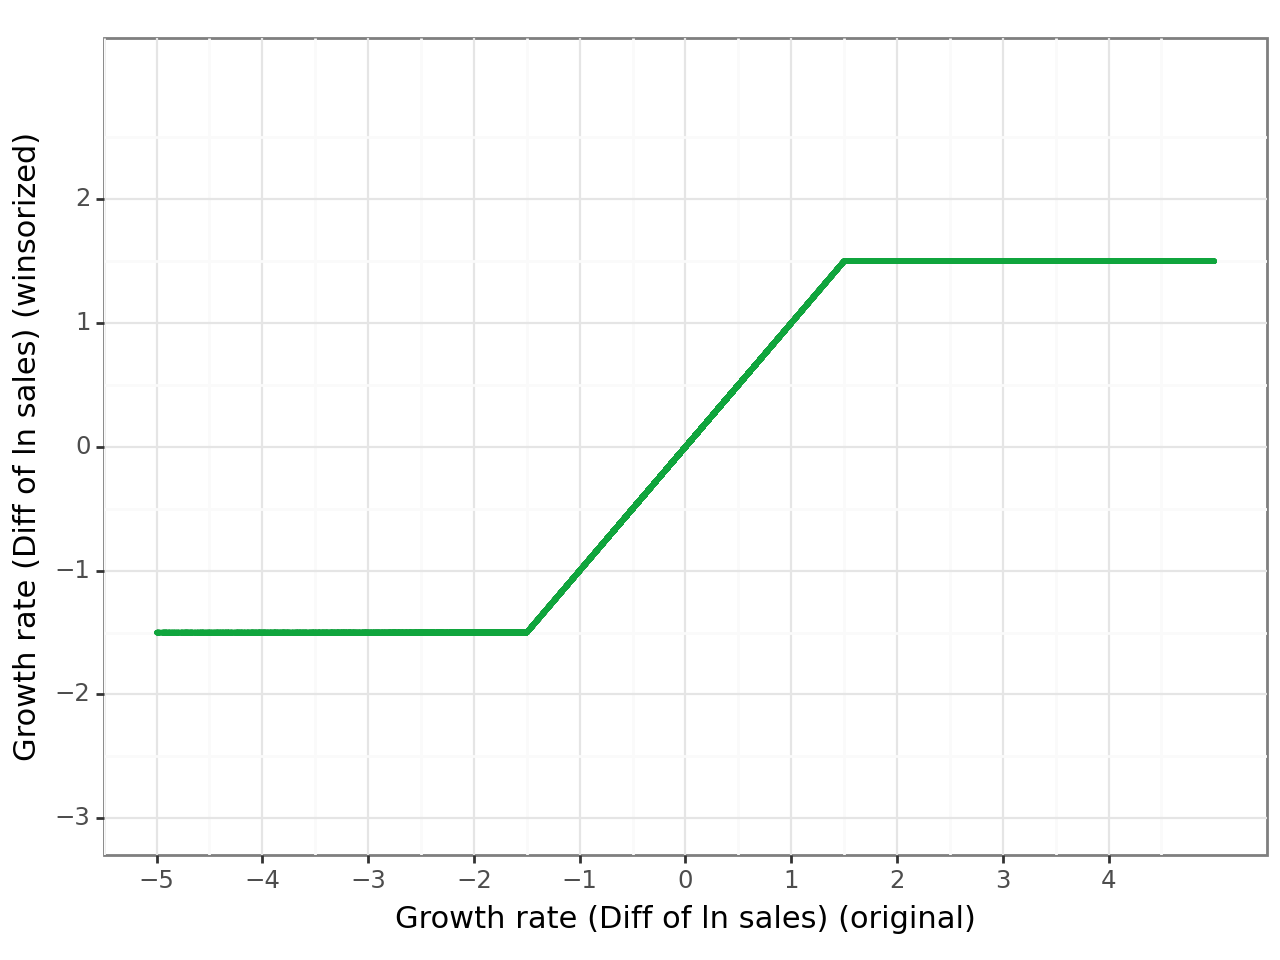

<Figure Size: (640 x 480)>

In [845]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

In [846]:
# Fill NAs

fillengvar3 = ['extra_exp_pl_flag_high',
 'extra_inc_pl_flag_high',
 'inventories_pl_flag_high',
 'material_exp_pl_flag_high',
 'personnel_exp_pl_flag_high',
 'curr_liab_bs_flag_high',
 'liq_assets_bs_flag_high',
 'subscribed_cap_bs_flag_high',
 'extra_exp_pl_flag_error',
 'extra_inc_pl_flag_error',
 'inventories_pl_flag_error',
 'material_exp_pl_flag_error',
 'personnel_exp_pl_flag_error',
 'curr_liab_bs_flag_error',
 'liq_assets_bs_flag_error',
 'subscribed_cap_bs_flag_error',
 'extra_profit_loss_pl_flag_low',
 'inc_bef_tax_pl_flag_low',
 'profit_loss_year_pl_flag_low',
 'share_eq_bs_flag_low',
 'extra_profit_loss_pl_flag_high',
 'inc_bef_tax_pl_flag_high',
 'profit_loss_year_pl_flag_high',
 'share_eq_bs_flag_high',
 'extra_profit_loss_pl_flag_zero',
 'inc_bef_tax_pl_flag_zero',
 'profit_loss_year_pl_flag_zero',
 'share_eq_bs_flag_zero']

for i in fillengvar3:
    data[i] = data[i].fillna(0)

data["liq_assets_bs"] = data["liq_assets_bs"].fillna(0)
data["foreign"] = data["foreign"].fillna(0)
data["material_exp_pl"] = data["material_exp_pl"].fillna(0)
data["foreign_management"] = data["foreign_management"].fillna(0)
data["sales_mil_log"] = data["sales_mil_log"].fillna(0)
data["sales_mil_log_sq"] = data["sales_mil_log_sq"].fillna(0)
data["d1_sales_mil_log_mod"] = data["d1_sales_mil_log_mod"].fillna(0)
data["profit_loss_year_pl"] = data["profit_loss_year_pl"].fillna(0)
data["fixed_assets_bs"] = data["fixed_assets_bs"].fillna(0)
data["share_eq_bs"] = data["share_eq_bs"].fillna(0)
data["curr_liab_bs"] = data["curr_liab_bs"].fillna(0)
data["curr_liab_bs_flag_high"] = data["curr_liab_bs_flag_high"].fillna(0)
data["curr_liab_bs_flag_error"] = data["curr_liab_bs_flag_error"].fillna(0)
data["age"] = data["age"].fillna(0)
data["age2"] = data["age2"].fillna(0)
data["total_assets_bs"] = data["total_assets_bs"].fillna(0)
data["curr_assets_bs"] = data["curr_assets_bs"].fillna(0)
data["subscribed_cap_bs"] = data["subscribed_cap_bs"].fillna(0)
data["intang_assets_bs"] = data["intang_assets_bs"].fillna(0)
data["extra_exp_pl"] = data["extra_exp_pl"].fillna(0)
data["extra_inc_pl"] = data["extra_inc_pl"].fillna(0)
data["extra_profit_loss_pl"] = data["extra_profit_loss_pl"].fillna(0)
data["inc_bef_tax_pl"] = data["inc_bef_tax_pl"].fillna(0)
data["inventories_pl"] = data["inventories_pl"].fillna(0)
data["personnel_exp_pl"] = data["personnel_exp_pl"].fillna(0)
data["extra_profit_loss_pl_quad"] = data["extra_profit_loss_pl_quad"].fillna(0)
data["inc_bef_tax_pl_quad"] = data["inc_bef_tax_pl_quad"].fillna(0)
data["profit_loss_year_pl_quad"] = data["profit_loss_year_pl_quad"].fillna(0)
data["share_eq_bs_quad"] = data["share_eq_bs_quad"].fillna(0)
data["female"] = data["female"].fillna(0)
data["ceo_count"] = data["ceo_count"].fillna(0)

In [847]:
data["profit_loss_year"].isna().value_counts()

profit_loss_year
False    268071
True        141
Name: count, dtype: int64

# Holdout Sample

In [848]:
data_holdout = data

# Existed in 2014 (sales > 0), but did not exists in 2015 (sales is 0 or missing)
Exist14 = data.loc[(data["year"] == 2014) & (data["sales"] > 0)]
Exist15 = data.loc[(data["year"] == 2015) & (data["sales"].isin([0, np.nan]))]

data_holdout = Exist14[~Exist14.index.isin(Exist15.index)]

# between 1000 and 10 million
data_holdout = data_holdout.loc[(data_holdout["sales"] > 1000) & (data_holdout["sales"] < 10000000)]

# ind2 == 26
data_holdout = data_holdout.loc[data_holdout["ind2"] == 26]

#data_train = data[~data.index.isin(data_holdout.index)]

data_holdout["sales"].describe()

count      1037.00000
mean     490202.21793
std     1154087.41432
min        1070.37036
25%       21766.66602
50%       72700.00000
75%      333888.87500
max     9576485.00000
Name: sales, dtype: float64

In [849]:
data_holdout["default"].value_counts()

default
0    981
1     56
Name: count, dtype: int64

In [850]:
data = data.reset_index()
data = data.drop("index", axis = 1)

# Helper Functions

In [851]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# Variable sets

In [852]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20240205)

In [853]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3 = []
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [854]:
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

In [855]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars]], axis=1)

In [869]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]]], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [857]:
y = data['default']

In [858]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=0.8, random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

# Simple linear and logistic models

In [859]:
ols_modelx1 = LinearRegression().fit(X1, y)
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.0086
r2:  0.0086
MAE:  0.0185
MSE:  0.0089
RMSE:  0.0945


In [860]:
create_coef_matrix(X1, ols_modelx1)

,variable,coefficient
0,sales_mil_log,-0.00176
1,sales_mil_log_sq,0.00021
2,d1_sales_mil_log_mod,-0.00761
3,Intercept,0.00132


In [861]:
data["year"].value_counts()

year
2014    27799
2013    27770
2015    27228
2012    27221
2011    26845
2010    25596
2009    24319
2008    22502
2007    20978
2006    19324
2005    18630
Name: count, dtype: int64

In [862]:
glm_modelx1 = LogisticRegression(
    solver="newton-cg",max_iter=1000, penalty="none", random_state = 20240205).fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  0.0
r2:  -0.0092
MAE:  0.0091
MSE:  0.0091
RMSE:  0.0954


In [863]:
create_coef_matrix(X1, glm_modelx1)

,variable,coefficient
0,sales_mil_log,-0.59450
1,sales_mil_log_sq,-0.03381
2,d1_sales_mil_log_mod,-0.60299
3,Intercept,-6.36595


In [864]:
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  0.0
r2:  -0.0092
MAE:  0.0091
MSE:  0.0091
RMSE:  0.0954


In [865]:
create_coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,sales_mil_log,-0.54227
1,sales_mil_log_sq,-0.02892
2,d1_sales_mil_log_mod,-0.61369
3,profit_loss_year_pl,-0.01759
4,fixed_assets_bs,-0.51483
5,share_eq_bs,-0.26009
6,curr_liab_bs,0.16933
7,curr_liab_bs_flag_high,0.25500
8,curr_liab_bs_flag_error,-0.23702
9,Intercept,-6.29660


In [866]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
print(mx2.summary())

Optimization terminated successfully.
         Current function value: 0.047340
         Iterations 10
        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0048      0.000    -17.187      0.000      -0.005      -0.004
sales_mil_log_sq           -0.0003   2.67e-05     -9.646      0.000      -0.000      -0.000
d1_sales_mil_log_mod       -0.0055      0.000    -16.494      0.000      -0.006      -0.005
profit_loss_year_pl        -0.0002      0.000     -0.382      0.703      -0.001       0.001
fixed_assets_bs            -0.0046      0.001     -8.157      0.000      -0.006      -0.003
share_eq_bs                -0.0023      0.000     -5.665      0.000      -0.003      -0.002
curr_liab

In [871]:
ols_model = LinearRegression().fit(X4, y)
regression_results(y, ols_model.predict(X4))

explained_variance:  0.018
r2:  0.018
MAE:  0.0196
MSE:  0.0089
RMSE:  0.0941


In [872]:
create_coef_matrix(X4, ols_model)

,variable,coefficient
0,sales_mil_log,-0.00122
1,sales_mil_log_sq,0.00013
2,total_assets_bs,0.00000
3,fixed_assets_bs,-0.01022
4,liq_assets_bs,0.00014
...,...,...
63,balsheet_length,0.00003
64,balsheet_notfullyear,0.01218
65,age,-0.00067
66,age2,0.00003


In [873]:
glm_model = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_model.predict(X4))

explained_variance:  0.0
r2:  -0.0092
MAE:  0.0091
MSE:  0.0091
RMSE:  0.0954


In [874]:
create_coef_matrix(X4, glm_model)

,variable,coefficient
0,sales_mil_log,0.00000
1,sales_mil_log_sq,-0.00000
2,total_assets_bs,-0.00000
3,fixed_assets_bs,-0.00000
4,liq_assets_bs,-0.00000
...,...,...
63,balsheet_length,-0.00000
64,balsheet_notfullyear,-0.00000
65,age,-0.00000
66,age2,-0.00000


In [875]:
# Get marginal effects
m = sm.Logit(y,sm.add_constant(X4)).fit().get_margeff()

         Current function value: 0.044761
         Iterations: 35


In [876]:
print(m.summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
sales_mil_log                     -0.0043      0.000    -13.324      0.000      -0.005      -0.004
sales_mil_log_sq                  -0.0002   3.06e-05     -7.863      0.000      -0.000      -0.000
total_assets_bs                 3.672e-12   4.05e-12      0.908      0.364   -4.26e-12    1.16e-11
fixed_assets_bs                   -0.0093      0.005     -2.041      0.041      -0.018      -0.000
liq_assets_bs                      0.0004      0.001      0.548      0.584      -0.001       0.002
curr_assets_bs                    -0.0061      0.005     -1.323      0.186      -0.015       0.003
share_eq_bs                    -6.411e-05      0.001    

In [877]:
t = m.summary().tables[1]
t

,dy/dx,std err,z,P>|z|,[0.025,0.975]
sales_mil_log,-0.0043,0.000,-13.324,0.000,-0.005,-0.004
sales_mil_log_sq,-0.0002,3.06e-05,-7.863,0.000,-0.000,-0.000
total_assets_bs,3.672e-12,4.05e-12,0.908,0.364,-4.26e-12,1.16e-11
fixed_assets_bs,-0.0093,0.005,-2.041,0.041,-0.018,-0.000
liq_assets_bs,0.0004,0.001,0.548,0.584,-0.001,0.002
curr_assets_bs,-0.0061,0.005,-1.323,0.186,-0.015,0.003
share_eq_bs,-6.411e-05,0.001,-0.092,0.927,-0.001,0.001
subscribed_cap_bs,0.0003,0.001,0.342,0.732,-0.001,0.002
intang_assets_bs,0.0015,0.006,0.247,0.805,-0.010,0.013
extra_exp_pl,0.0186,0.008,2.224,0.026,0.002,0.035


In [878]:
columns = pd.DataFrame(t.data).iloc[0].tolist()

In [879]:
df_marginal_effects = pd.DataFrame(t.data, columns = columns).iloc[1:].astype(
    {'dy/dx': float, 'P>|z|': float})
df_marginal_effects[df_marginal_effects['P>|z|'] <= 0.05].sort_values(by = 'dy/dx', ascending = False).reset_index(drop = True)

,,dy/dx,std err,z,P>|z|,[0.025,0.975]
0,extra_exp_pl,0.01860,0.008,2.224,0.02600,0.002,0.035
1,extra_inc_pl_flag_error,0.01420,0.007,2.147,0.03200,0.001,0.027
2,balsheet_flag,0.00970,0.002,5.148,0.00000,0.006,0.013
3,inventories_pl_flag_high,0.00960,0.002,5.160,0.00000,0.006,0.013
4,balsheet_notfullyear,0.00870,0.001,9.004,0.00000,0.007,0.011
5,foreign_management,0.00840,0.001,12.660,0.00000,0.007,0.010
6,flag_high_ceo_age,0.00540,0.002,2.640,0.00800,0.001,0.009
7,share_eq_bs_flag_low,0.00460,0.001,3.720,0.00000,0.002,0.007
8,d1_sales_mil_log_mod_sq,0.00440,0.001,8.298,0.00000,0.003,0.005
9,extra_profit_loss_pl_flag_zero,0.00360,0.001,4.647,0.00000,0.002,0.005


# Predictions using cross-validations